based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [1]:
from IPython.display import display, Markdown, HTML, clear_output

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor, Resize, Normalize, Compose


from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

from datasets import load_dataset

from accelerate import Accelerator

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import timeit
import json

import os
import time

import numpy as np
from scipy.linalg import sqrtm


# ignore UserWarning
import warnings
warnings.filterwarnings("ignore")

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torch.utils.data import DataLoader

IMG_SIZE = 128
DATASET_PERCENTAGE = 0.1

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Load your dataset
local_dataset_path = f"data/square{IMG_SIZE}_random{str(DATASET_PERCENTAGE)}_train/"

custom_dataset = ImageFolder(root=local_dataset_path, transform=preprocess)
train_loader = DataLoader(custom_dataset, batch_size=16, shuffle=True)


FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'data/square128_random0.1_train/'

In [ ]:
# UNet model
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


# Scheduler for DDPM
scheduler = DDPMScheduler(num_train_timesteps=1000)

pipeline = DDPMPipeline(unet=model, scheduler=scheduler)



In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples]
    return {"images": images}



In [ ]:
# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4/2)

In [ ]:
if not os.path.exists("models/unet_15.pt"):
    num_epochs = 15
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        for batch in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, _ = batch
            images = images.to(device)
            
            # Sample noise
            noise = torch.randn(images.shape).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.shape[0],), device=device).long()
            
            # Forward diffusion process
            noisy_images = scheduler.add_noise(images, noise, timesteps)
            
            # Get model prediction
            noise_pred = model(noisy_images, timesteps).sample
            
            # Calculate loss
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"models/unet_{epoch+1}.pt")
            model.eval()
            with torch.no_grad():
                sampled_images = pipeline(batch_size=9, generator=torch.manual_seed(42)).images
                transformed_image = transform(sampled_images)
                fig, ax = plt.subplots(3, 3, figsize=(10, 10))
                for i in range(3):
                    for j in range(3):
                        ax[i, j].imshow(transformed_image["images"][i*3+j].permute(1, 2, 0))
                        ax[i, j].axis("off")
                plt.show()


In [ ]:
# read unet model
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

model.load_state_dict(torch.load("models/unet_15.pt"))
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [ ]:
# Function to extract latent representation
def extract_latent(model, image, timesteps, device):
    model.eval()
    with torch.no_grad():
        latent = model(image.to(device), timesteps.to(device)).sample
    return latent

# Function to generate image from latent
def generate_from_latent(model, scheduler, latent, timesteps, device):
    model.eval()
    with torch.no_grad():
        for t in tqdm(reversed(range(scheduler.num_train_timesteps)),total=scheduler.num_train_timesteps, desc="Generating"):
            latent = scheduler.step(model(latent, t).sample, t, latent).prev_sample
    return latent

# Example usage
example_batch = next(iter(train_loader))
example_images, _ = example_batch
example_images = example_images.to(device)
#preprocess example images
example_images = preprocess(example_images)
timesteps = torch.randint(0, scheduler.num_train_timesteps, (example_images.shape[0],), device=device).long()

latents = extract_latent(model, example_images, timesteps, device)
generated_images = generate_from_latent(model, scheduler, latents, timesteps, device)

# Convert to displayable format
generated_images = (generated_images / 2 + 0.5).clamp(0, 1)


Generating:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


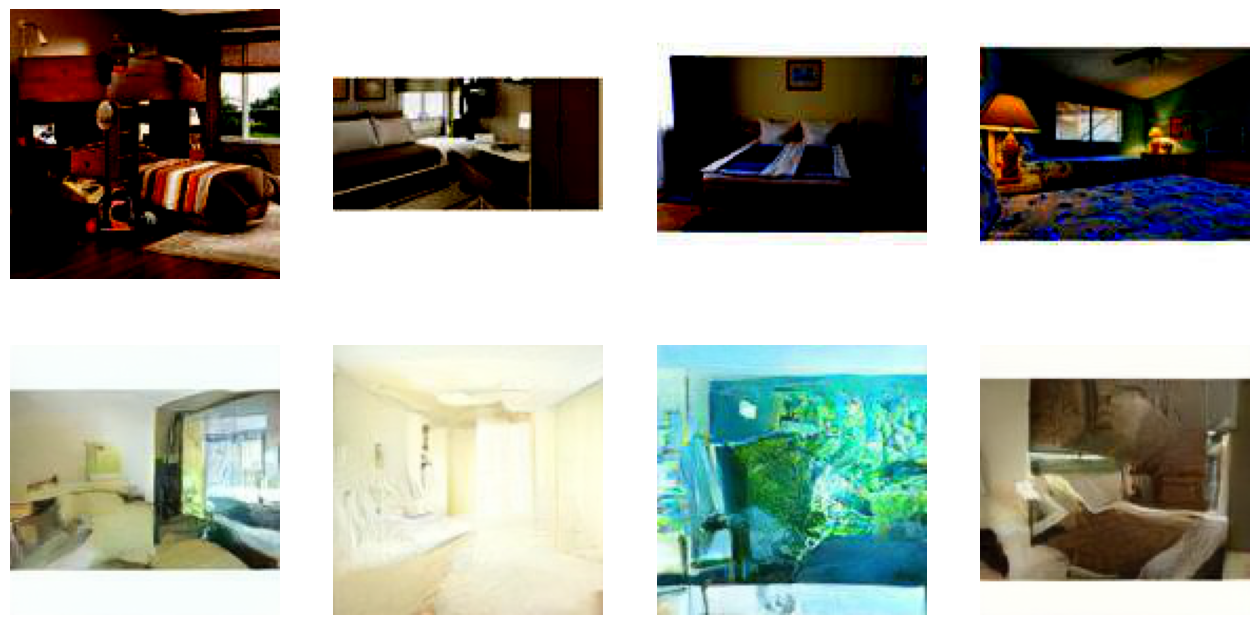

In [ ]:
# plot the original and generated images
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    ax[0, i].imshow(example_images[i].permute(1, 2, 0).cpu())
    ax[0, i].axis("off")
    ax[1, i].imshow(generated_images[i].permute(1, 2, 0).cpu())
    ax[1, i].axis("off")

In [ ]:
import matplotlib.pyplot as plt

# Select two images and their latent vectors
idx1, idx2 = 0, 3 
latent1 = latents[idx1].unsqueeze(0)
latent2 = latents[idx2].unsqueeze(0)

# Generate 8 additional latent vectors through linear interpolation
interpolated_latents = []
num_interpolations = 8
for i in range(1, num_interpolations + 1):
    alpha = i / (num_interpolations + 1)
    interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
    interpolated_latents.append(interpolated_latent)

# Convert list to tensor
interpolated_latents = torch.cat(interpolated_latents, dim=0)

# Generate images from the interpolated latent vectors
interpolated_images = generate_from_latent(model, scheduler, interpolated_latents, timesteps[:num_interpolations], device)

# Convert images to displayable format
interpolated_images = (interpolated_images / 2 + 0.5).clamp(0, 1)




Generating:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


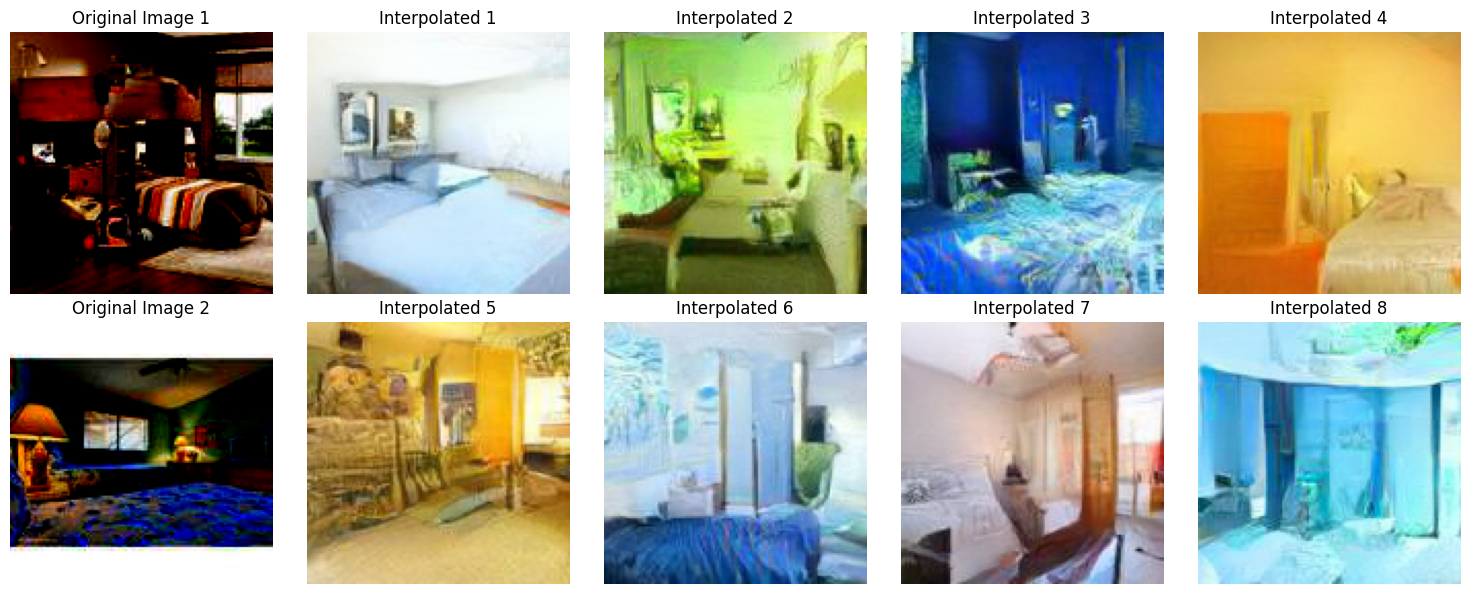

In [ ]:
# Plot the original and interpolated images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
# Display original images
axes[0].imshow(example_images[idx1].permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image 1")
axes[0].axis("off")

axes[5].imshow(example_images[idx2].permute(1, 2, 0).cpu().numpy())
axes[5].set_title("Original Image 2")
axes[5].axis("off")

# Display interpolated images
for i, img in enumerate(interpolated_images):
    n_ax = i + 1 if i < 4 else i + 2
    axes[n_ax].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[n_ax].set_title(f"Interpolated {i + 1}")
    axes[n_ax].axis("off")

plt.tight_layout()
plt.show()